We implement a simplified version of the detection algorithm described in the following article :  
Y. Meidan, M. Bohadana, Y. Mathov, Y. Mirsky, D. Breitenbacher, A. Shabtai, and Y. Elovici 'N-BaIoT:  
Network-based Detection of IoT Botnet Attacks Using Deep Autoencoders',   
IEEE Pervasive Computing, Special Issue - Securing the IoT (July/Sep 2018). 


The results are not reproducible with Tensorflow 2.0 :
https://github.com/keras-team/keras/issues/12800

In [1]:
from glob import glob
from os.path import basename

import pandas as pd
import numpy as np

from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)

Using TensorFlow backend.


# Read datasets  
## Benign data

In [2]:
DATA_DIR = "/home/drussier/proj/job/jumio/Ecobee_Thermostat/"

In [3]:
# project structure
! tree $DATA_DIR

/home/drussier/proj/job/jumio/Ecobee_Thermostat/
├── benign_traffic.csv.bz2
├── count.txt
├── gafgyt
│   ├── combo.csv.bz2
│   ├── gafgyt_attacks.rar
│   ├── junk.csv.bz2
│   ├── scan.csv.bz2
│   ├── tcp.csv.bz2
│   └── udp.csv.bz2
├── Jumio_ DS take-home assignment.pdf
└── mirai
    ├── ack.csv.bz2
    ├── mirai_attacks.rar
    ├── scan.csv.bz2
    ├── syn.csv.bz2
    ├── udp.csv.bz2
    └── udpplain.csv.bz2

2 directories, 15 files


In [4]:
! bzcat $DATA_DIR"benign_traffic.csv.bz2" | head -2




bzcat: I/O or other error, bailing out.  Possible reason follows.
bzcat: Broken pipe
	Input file = /home/drussier/proj/job/jumio/Ecobee_Thermostat/benign_traffic.csv.bz2, output file = (stdout)


In [5]:
def read_input_file(fpath, n_rows=None):
    """ read compressed csv input file
    
    Parameters:
    fpath : full file name 
    n_rows : read only n_rows rows (for debug)
    
    Returns:
    pandas dataframe
    """
    
    df = pd.read_csv(fpath, sep=',', compression="bz2", nrows=n_rows)
    n_features = len(df.columns)
    assert n_features == 115, "dataframe should have 115 != {} columns".format(n_features)
    print("dataframe dimensions :", df.shape)
    print("first rows :")
    display(df.head())
    print("basic statistics :")
    display(df.describe())
    return df

In [6]:
benign_df = read_input_file(DATA_DIR + "benign_traffic.csv.bz2")

dataframe dimensions : (13113, 115)
first rows :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0          1.000000       60.000000            0.000000          1.000000   
1          1.000000      110.000000            0.000000          1.000000   
2          1.724055       91.439104          249.441812          1.823878   
3          1.000000      342.000000            0.000000          1.000000   
4          2.516815       90.867308          150.827639          2.688981   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0       60.000000            0.000000          1.000000       60.000000   
1      110.000000            0.000000          1.000000      110.000000   
2       92.454965          253.612868          1.937463       93.483558   
3      342.000000            0.000000          1.000000      342.000000   
4       91.541993          160.705060          2.888469       92.277536   

   MI_dir_L1_variance  MI_dir_L0.1_weight       ...        HpHp_L0.1_radius  \
0            0.000000            1.000000       ...            0.000000e+00   
1            0.000000            1.000000       ...            1.020000e-07   
2          255.733288            1.993563       ...            0.000000e+00   
3            0.000000            1.000000       ...            2.740000e-07   
4          169.944112            2.988463       ...            9.999797e+01   

   HpHp_L0.1_covariance  HpHp_L0.1_pcc  HpHp_L0.01_weight  HpHp_L0.01_mean  \
0                   0.0            0.0           1.000000        60.000000   
1                   0.0            0.0           1.238636       106.146795   
2                   0.0            0.0           1.000000        78.000000   
3                   0.0            0.0           2.487473       341.959189   
4                   0.0            0.0           2.237519        98.930412   

   HpHp_L0.01_std  HpHp_L0.01_magnitude  HpHp_L0.01_radius  \
0        0.000000             60.000000           0.000000   
1        7.887770            106.146795          62.216910   
2        0.000000             78.000000           0.000000   
3        7.347919            341.959189          53.991908   
4        9.942635             98.930412          98.855983   

   HpHp_L0.01_covariance  HpHp_L0.01_pcc  
0                    0.0             0.0  
1                    0.0             0.0  
2                    0.0             0.0  
3                    0.0             0.0  
4                    0.0             0.0  

[5 rows x 115 columns]

basic statistics :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count      13113.000000    13113.000000        13113.000000      13113.000000   
mean           1.143693      207.558777         6347.444780          1.237423   
std            0.240561      147.073074        13270.956252          0.344167   
min            1.000000       60.000000            0.000000          1.000000   
25%            1.000000       67.260967            0.000000          1.000000   
50%            1.000002      143.369009            0.003028          1.000400   
75%            1.255613      380.000000        12421.740450          1.459779   
max            4.311646     1108.154953       272101.712800          4.660031   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count    13113.000000        13113.000000      13113.000000    13113.000000   
mean       215.447437         8247.564185          1.495936      229.725019   
std        140.564282        15461.799362          0.625399      128.676918   
min         60.000000            0.000000          1.000000       60.000000   
25%         76.863969            0.000000          1.000000      110.000000   
50%        173.945624            3.637611          1.146569      207.516344   
75%        379.999996        18596.581500          1.807384      379.589658   
max       1090.333261       269315.913000          7.895283      940.451256   

       MI_dir_L1_variance  MI_dir_L0.1_weight       ...        \
count        13113.000000        13113.000000       ...         
mean         11186.886485            2.561774       ...         
std          16304.208130            1.326598       ...         
min              0.000000            1.000000       ...         
25%              0.002310            1.533641       ...         
50%           2284.841419            2.424449       ...         
75%          21701.924530            3.223457       ...         
max         241627.942700           16.276783       ...         

       HpHp_L0.1_radius  HpHp_L0.1_covariance  HpHp_L0.1_pcc  \
count      1.311300e+04          1.311300e+04   13113.000000   
mean       1.991946e+04         -2.185876e+03      -0.095595   
std        2.815120e+04          4.696020e+03       0.176809   
min        0.000000e+00         -4.005854e+04      -1.010724   
25%        1.020000e-12         -1.493373e+03      -0.144148   
50%        2.166666e+04         -2.281024e-01      -0.000647   
75%        2.736170e+04          1.470000e-51       0.000000   
max        3.906840e+05          3.384711e+04       0.863180   

       HpHp_L0.01_weight  HpHp_L0.01_mean  HpHp_L0.01_std  \
count       13113.000000     13113.000000    13113.000000   
mean            7.482557       196.888164      115.331205   
std             3.659873        88.153201       79.964031   
min             1.000000        60.000000        0.000000   
25%             3.109186        95.866938        0.000001   
50%             8.650998       240.705657      153.390362   
75%            10.138847       257.096398      165.290205   
max            23.121981       590.000000      321.653614   

       HpHp_L0.01_magnitude  HpHp_L0.01_radius  HpHp_L0.01_covariance  \
count          13113.000000       1.311300e+04           13113.000000   
mean             293.124946       3.133270e+04           -2987.055998   
std              142.438909       3.029417e+04            5020.331327   
min               60.000000       0.000000e+00          -39463.345860   
25%               96.857099       1.820000e-12           -5043.948599   
50%              367.783583       3.445461e+04            -836.545275   
75%              390.436727       4.201832e+04               0.000000   
max              681.956010       3.641805e+05           26797.441690   

       HpHp_L0.01_pcc  
count    13113.000000  
mean        -0.094352  
std          0.141092  
min         -0.690911  
25%         -0.185178  
50%         -0.030725  
75%          0.000000  
ma

## Other datasets

In [7]:
def read_test_datasets(data_dir, n_rows=None):
    """ read compressed csv test files
    
    Parameters:
    data_dir : data directory 
    n_rows : read only n_rows rows (for debug)
    
    Returns:
    list of pandas dataframes
    """
    datasets = []
    for folder in ['mirai', 'gafgyt']:
        for fpath in glob(data_dir + "{}/*.csv.bz2".format(folder)):
            df = read_input_file(fpath, n_rows=n_rows)
            datasets.append(("{} - {}".format(folder, basename(fpath).split('.')[0]), df))
            
    return datasets

In [8]:
datasets = read_test_datasets(DATA_DIR) # , n_rows=1000)

dataframe dimensions : (113285, 115)
first rows :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0          1.000000           566.0        0.000000e+00          1.000000   
1          1.996582           566.0        0.000000e+00          1.997948   
2          2.969101           566.0        5.820766e-11          2.981402   
3          3.939044           566.0        5.820766e-11          3.963256   
4          4.917028           566.0        1.164153e-10          4.949951   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0           566.0        0.000000e+00          1.000000           566.0   
1           566.0        5.820766e-11          1.999315           566.0   
2           566.0        0.000000e+00          2.993781           566.0   
3           566.0        0.000000e+00          3.987695           566.0   
4           566.0        0.000000e+00          4.983228           566.0   

   MI_dir_L1_variance  MI_dir_L0.1_weight       ...        HpHp_L0.1_radius  \
0        0.000000e+00            1.000000       ...                     0.0   
1        0.000000e+00            1.999932       ...                     0.0   
2        5.820766e-11            2.999377       ...                     0.0   
3        0.000000e+00            3.998767       ...                     0.0   
4        0.000000e+00            4.998319       ...                     0.0   

   HpHp_L0.1_covariance  HpHp_L0.1_pcc  HpHp_L0.01_weight  HpHp_L0.01_mean  \
0                   0.0            0.0                1.0            566.0   
1                   0.0            0.0                1.0            566.0   
2                   0.0            0.0                1.0            566.0   
3                   0.0            0.0                1.0            566.0   
4                   0.0            0.0                1.0            566.0   

   HpHp_L0.01_std  HpHp_L0.01_magnitude  HpHp_L0.01_radius  \
0             0.0                 566.0                0.0   
1             0.0                 566.0                0.0   
2             0.0                 566.0                0.0   
3             0.0                 566.0                0.0   
4             0.0                 566.0                0.0   

   HpHp_L0.01_covariance  HpHp_L0.01_pcc  
0                    0.0             0.0  
1                    0.0             0.0  
2                    0.0             0.0  
3                    0.0             0.0  
4                    0.0             0.0  

[5 rows x 115 columns]

basic statistics :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count     113285.000000   113285.000000       113285.000000     113285.000000   
mean         132.610777      440.815823        39586.211928        214.680958   
std           31.513838       89.777024        20970.809035         38.570869   
min            1.000000       60.010834            0.000000          1.000000   
25%          110.132703      367.845837        19003.911889        188.452835   
50%          130.381222      452.258002        44192.467365        213.852684   
75%          154.222068      524.460604        60516.649803        240.452474   
max          248.879791      566.000000        64008.999997        345.873348   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count   113285.000000       113285.000000     113285.000000   113285.000000   
mean       439.781691        43640.994182        626.546302      438.038542   
std         65.334789        15448.134692         62.189415       28.754828   
min         61.013153            0.000000          1.000000      157.061999   
25%        390.075098        30305.113963        588.068581      419.815713   
50%        444.824181        46430.397937        628.189411      439.798207   
75%        496.022970        57905.323319        665.161554      458.593618   
max        566.000000        64008.999996        818.552794      566.000000   

       MI_dir_L1_variance  MI_dir_L0.1_weight       ...        \
count       113285.000000       113285.000000       ...         
mean         47522.181099         6105.651455       ...         
std           6347.350608          342.396886       ...         
min              0.000000            1.000000       ...         
25%          42780.006793         5970.248396       ...         
50%          47887.445618         6145.070306       ...         
75%          52546.808079         6347.750060       ...         
max          64000.524369         6619.558692       ...         

       HpHp_L0.1_radius  HpHp_L0.1_covariance  HpHp_L0.1_pcc  \
count      1.132850e+05              113285.0       113285.0   
mean       3.267549e-15                   0.0            0.0   
std        1.879147e-13                   0.0            0.0   
min        0.000000e+00                   0.0            0.0   
25%        0.000000e+00                   0.0            0.0   
50%        0.000000e+00                   0.0            0.0   
75%        0.000000e+00                   0.0            0.0   
max        5.820766e-11                   0.0            0.0   

       HpHp_L0.01_weight  HpHp_L0.01_mean  HpHp_L0.01_std  \
count      113285.000000    113285.000000    1.132850e+05   
mean            1.014357       437.096385    2.482647e-09   
std             0.323317       220.418498    5.665006e-08   
min             1.000000        60.000000    0.000000e+00   
25%             1.000000        60.000000    0.000000e+00   
50%             1.000000       566.000000    0.000000e+00   
75%             1.000000       566.000000    0.000000e+00   
max            14.606232       566.000000    2.132481e-06   

       HpHp_L0.01_magnitude  HpHp_L0.01_radius  HpHp_L0.01_covariance  \
count         113285.000000       1.132850e+05               113285.0   
mean             437.096385       3.215365e-15                    0.0   
std              220.418498       8.150739e-14                    0.0   
min               60.000000       0.000000e+00                    0.0   
25%               60.000000       0.000000e+00                    0.0   
50%              566.000000       0.000000e+00                    0.0   
75%              566.000000       0.000000e+00                    0.0   
max              566.000000       4.547474e-12                    0.0   

       HpHp_L0.01_pcc  
count        113285.0  
mean              0.0  
std               0.0  
min               0.0  
25%               0.0  
50%               0.0  
75%               0.0  
ma

dataframe dimensions : (151481, 115)
first rows :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0          1.000000            60.0        0.000000e+00          1.000000   
1          1.999969            60.0        9.094947e-13          1.999982   
2          2.999961            60.0        9.094947e-13          2.999977   
3          3.999857            60.0        0.000000e+00          3.999914   
4          4.999761            60.0        4.547474e-13          4.999857   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0            60.0        0.000000e+00          1.000000            60.0   
1            60.0        4.547474e-13          1.999994            60.0   
2            60.0        0.000000e+00          2.999992            60.0   
3            60.0        0.000000e+00          3.999971            60.0   
4            60.0        0.000000e+00          4.999952            60.0   

   MI_dir_L1_variance  MI_dir_L0.1_weight       ...        HpHp_L0.1_radius  \
0        0.000000e+00            1.000000       ...                     0.0   
1        9.094947e-13            1.999999       ...                     0.0   
2        0.000000e+00            2.999999       ...                     0.0   
3        4.547474e-13            3.999997       ...                     0.0   
4        1.818989e-12            4.999995       ...                     0.0   

   HpHp_L0.1_covariance  HpHp_L0.1_pcc  HpHp_L0.01_weight  HpHp_L0.01_mean  \
0                   0.0            0.0                1.0             60.0   
1                   0.0            0.0                1.0             60.0   
2                   0.0            0.0                1.0             60.0   
3                   0.0            0.0                1.0             60.0   
4                   0.0            0.0                1.0             60.0   

   HpHp_L0.01_std  HpHp_L0.01_magnitude  HpHp_L0.01_radius  \
0             0.0                  60.0                0.0   
1             0.0                  60.0                0.0   
2             0.0                  60.0                0.0   
3             0.0                  60.0                0.0   
4             0.0                  60.0                0.0   

   HpHp_L0.01_covariance  HpHp_L0.01_pcc  
0                    0.0             0.0  
1                    0.0             0.0  
2                    0.0             0.0  
3                    0.0             0.0  
4                    0.0             0.0  

[5 rows x 115 columns]

basic statistics :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count     151481.000000   151481.000000       151481.000000     151481.000000   
mean         138.501395      429.185551        38034.075161        224.158922   
std           33.955064       89.595599        19617.047721         43.832825   
min            1.000000       60.000000            0.000000          1.000000   
25%          114.427030      359.632688        18894.984457        194.929635   
50%          136.562164      441.998802        42029.792873        223.091332   
75%          161.235682      510.730240        57635.859737        252.280953   
max          279.873101      549.018483        61009.000000        383.067537   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count   151481.000000       151481.000000     151481.000000   151481.000000   
mean       428.011012        41938.451282        649.957174      426.349138   
std         66.397157        14347.456431         81.954548       33.063727   
min         60.000000            0.000000          1.000000       60.000000   
25%        381.736819        29797.151952        606.488153      410.184645   
50%        435.150675        44190.600408        649.415181      429.443770   
75%        482.501457        55148.646915        694.649112      447.432795   
max        531.393415        61008.999838        943.803472      487.470311   

       MI_dir_L1_variance  MI_dir_L0.1_weight       ...        \
count       151481.000000       151481.000000       ...         
mean         45653.203933         6136.605376       ...         
std           5907.125225          869.045163       ...         
min              0.000000            1.000000       ...         
25%          41204.857434         6140.013023       ...         
50%          45932.079712         6336.514404       ...         
75%          50269.021100         6519.414803       ...         
max          61008.999407         7014.905312       ...         

       HpHp_L0.1_radius  HpHp_L0.1_covariance  HpHp_L0.1_pcc  \
count      1.514810e+05              151481.0       151481.0   
mean       3.296206e-15                   0.0            0.0   
std        3.408974e-13                   0.0            0.0   
min        0.000000e+00                   0.0            0.0   
25%        0.000000e+00                   0.0            0.0   
50%        0.000000e+00                   0.0            0.0   
75%        0.000000e+00                   0.0            0.0   
max        1.164153e-10                   0.0            0.0   

       HpHp_L0.01_weight  HpHp_L0.01_mean  HpHp_L0.01_std  \
count      151481.000000    151481.000000    1.514810e+05   
mean            1.010474       425.990362    1.830453e-09   
std             0.266617       216.407506    5.462296e-08   
min             1.000000        60.000000    0.000000e+00   
25%             1.000000        60.000000    0.000000e+00   
50%             1.000000       554.000000    0.000000e+00   
75%             1.000000       554.000000    0.000000e+00   
max            13.652423       554.000000    1.078959e-05   

       HpHp_L0.01_magnitude  HpHp_L0.01_radius  HpHp_L0.01_covariance  \
count         151481.000000       1.514810e+05               151481.0   
mean             425.990362       2.986999e-15                    0.0   
std              216.407506       3.062385e-13                    0.0   
min               60.000000       0.000000e+00                    0.0   
25%               60.000000       0.000000e+00                    0.0   
50%              554.000000       0.000000e+00                    0.0   
75%              554.000000       0.000000e+00                    0.0   
max              554.000000       1.164153e-10                    0.0   

       HpHp_L0.01_pcc  
count        151481.0  
mean              0.0  
std               0.0  
min               0.0  
25%               0.0  
50%               0.0  
75%               0.0  
ma

dataframe dimensions : (116807, 115)
first rows :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0          1.000000            74.0        0.000000e+00          1.000000   
1          1.995653            74.0        0.000000e+00          1.997390   
2          2.984032            74.0        0.000000e+00          2.990403   
3          3.952494            74.0        0.000000e+00          3.971399   
4          4.931439            74.0        9.094947e-13          4.958692   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0            74.0        0.000000e+00          1.000000            74.0   
1            74.0        1.818989e-12          1.999129            74.0   
2            74.0        1.818989e-12          2.996795            74.0   
3            74.0        1.818989e-12          3.990434            74.0   
4            74.0        1.818989e-12          4.986173            74.0   

   MI_dir_L1_variance  MI_dir_L0.1_weight       ...        HpHp_L0.1_radius  \
0        0.000000e+00            1.000000       ...                     0.0   
1        0.000000e+00            1.999913       ...                     0.0   
2        9.094947e-13            2.999679       ...                     0.0   
3        0.000000e+00            3.999042       ...                     0.0   
4        9.094947e-13            4.998615       ...                     0.0   

   HpHp_L0.1_covariance  HpHp_L0.1_pcc  HpHp_L0.01_weight  HpHp_L0.01_mean  \
0                   0.0            0.0                1.0             74.0   
1                   0.0            0.0                1.0             74.0   
2                   0.0            0.0                1.0             74.0   
3                   0.0            0.0                1.0             74.0   
4                   0.0            0.0                1.0             74.0   

   HpHp_L0.01_std  HpHp_L0.01_magnitude  HpHp_L0.01_radius  \
0             0.0                  74.0                0.0   
1             0.0                  74.0                0.0   
2             0.0                  74.0                0.0   
3             0.0                  74.0                0.0   
4             0.0                  74.0                0.0   

   HpHp_L0.01_covariance  HpHp_L0.01_pcc  
0                    0.0             0.0  
1                    0.0             0.0  
2                    0.0             0.0  
3                    0.0             0.0  
4                    0.0             0.0  

[5 rows x 115 columns]

basic statistics :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count     116807.000000   116807.000000       116807.000000     116807.000000   
mean         149.644714       70.887719           28.755407        242.673709   
std           40.929842        2.339545           16.153467         55.904323   
min            1.000000       60.467518            0.000000          1.000000   
25%          119.945039       69.064630           12.597452        204.413871   
50%          145.100728       71.311190           30.670382        235.578866   
75%          174.302534       73.062517           44.782908        271.864657   
max          351.924519       74.275451           87.137515        505.805302   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count   116807.000000       116807.000000     116807.000000   116807.000000   
mean        70.858638           31.681515        705.315538       70.811760   
std          1.665374           11.960831        112.106021        0.681260   
min         62.125985            0.000000          1.000000       68.480846   
25%         69.616958           21.076548        634.653001       70.320496   
50%         71.034853           33.030630        683.046597       70.843459   
75%         72.316122           42.405992        743.229959       71.345694   
max         74.000000           60.297553       1185.249664       74.000000   

       MI_dir_L1_variance  MI_dir_L0.1_weight       ...        \
count       116807.000000       116807.000000       ...         
mean            34.349566         6690.400084       ...         
std              5.213210          689.003824       ...         
min              0.000000            1.000000       ...         
25%             30.441021         6441.936839       ...         
50%             34.525319         6610.441603       ...         
75%             38.304357         6890.903691       ...         
max             50.541085         8912.649148       ...         

       HpHp_L0.1_radius  HpHp_L0.1_covariance  HpHp_L0.1_pcc  \
count     116807.000000              116807.0       116807.0   
mean           0.000419                   0.0            0.0   
std            0.143371                   0.0            0.0   
min            0.000000                   0.0            0.0   
25%            0.000000                   0.0            0.0   
50%            0.000000                   0.0            0.0   
75%            0.000000                   0.0            0.0   
max           48.999997                   0.0            0.0   

       HpHp_L0.01_weight  HpHp_L0.01_mean  HpHp_L0.01_std  \
count      116807.000000    116807.000000   116807.000000   
mean            1.008060        70.789448        0.000060   
std             0.203751         5.914176        0.020482   
min             1.000000        60.000000        0.000000   
25%             1.000000        74.000000        0.000000   
50%             1.000000        74.000000        0.000000   
75%             1.000000        74.000000        0.000000   
max             9.836576        98.000000        7.000000   

       HpHp_L0.01_magnitude  HpHp_L0.01_radius  HpHp_L0.01_covariance  \
count         116807.000000      116807.000000               116807.0   
mean              70.789448           0.000419                    0.0   
std                5.914176           0.143371                    0.0   
min               60.000000           0.000000                    0.0   
25%               74.000000           0.000000                    0.0   
50%               74.000000           0.000000                    0.0   
75%               74.000000           0.000000                    0.0   
max               98.000000          49.000000                    0.0   

       HpHp_L0.01_pcc  
count        116807.0  
mean              0.0  
std               0.0  
min               0.0  
25%               0.0  
50%               0.0  
75%               0.0  
ma

dataframe dimensions : (87368, 115)
first rows :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0          1.000000       60.000000            0.000000          1.000000   
1          1.970042      310.756080        60994.891862          1.981916   
2          2.969668      392.665557        53670.412293          2.981690   
3          3.956808      433.439444        45022.066988          3.973936   
4          4.886598      458.111117        38174.430233          4.931477   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0       60.000000            0.000000          1.000000       60.000000   
1      309.253759        61003.920569          1.993935      307.751272   
2      391.336821        53896.300650          2.993859      390.002536   
3      432.269329        45316.595182          3.991262      431.091660   
4      456.953755        38522.871312          4.976996      455.786945   

   MI_dir_L1_variance  MI_dir_L0.1_weight       ...        HpHp_L0.1_radius  \
0            0.000000            1.000000       ...            0.000000e+00   
1        61008.435591            1.999392       ...            0.000000e+00   
2        54119.579009            2.999384       ...            0.000000e+00   
3        45610.259923            3.999124       ...            0.000000e+00   
4        38871.445102            4.997692       ...            1.164153e-10   

   HpHp_L0.1_covariance  HpHp_L0.1_pcc  HpHp_L0.01_weight  HpHp_L0.01_mean  \
0                   0.0            0.0           1.000000             60.0   
1                   0.0            0.0           1.000000            554.0   
2                   0.0            0.0           2.000000            554.0   
3                   0.0            0.0           2.999982            554.0   
4                   0.0            0.0           3.999875            554.0   

   HpHp_L0.01_std  HpHp_L0.01_magnitude  HpHp_L0.01_radius  \
0        0.000000                  60.0       0.000000e+00   
1        0.000000                 554.0       0.000000e+00   
2        0.000008                 554.0       5.820766e-11   
3        0.000008                 554.0       5.820766e-11   
4        0.000000                 554.0       0.000000e+00   

   HpHp_L0.01_covariance  HpHp_L0.01_pcc  
0                    0.0             0.0  
1                    0.0             0.0  
2                    0.0             0.0  
3                    0.0             0.0  
4                    0.0             0.0  

[5 rows x 115 columns]

basic statistics :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count      87368.000000    87368.000000        87368.000000      87368.000000   
mean         117.299599      405.118705        42445.607134        186.977365   
std           41.365621       94.376730        18632.008777         53.613824   
min            1.000000       60.000000            0.000000          1.000000   
25%           89.211035      326.640183        25692.622611        151.780182   
50%          112.587734      407.035806        50457.086508        180.939731   
75%          139.293751      494.866516        59187.654530        213.468644   
max          438.002839      553.619444        61008.999966        497.313584   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count    87368.000000        87368.000000      87368.000000    87368.000000   
mean       404.088622        46880.086448        536.737477      402.492417   
std         68.363349        13361.651441        111.287642       31.660177   
min         60.000000            0.000000          1.000000       60.000000   
25%        350.160197        36654.345646        468.562117      380.443525   
50%        405.746131        51218.484522        526.677915      402.836540   
75%        462.910734        58875.805023        584.857352      425.216663   
max        545.531187        61008.999996       1072.450467      493.133708   

       MI_dir_L1_variance  MI_dir_L0.1_weight       ...        \
count        87368.000000        87368.000000       ...         
mean         50859.277743         5152.736946       ...         
std           6140.602121          634.466874       ...         
min              0.000000            1.000000       ...         
25%          47005.982678         4752.271610       ...         
50%          51790.424497         5433.817407       ...         
75%          55585.166330         5595.340609       ...         
max          61008.435591         6258.476140       ...         

       HpHp_L0.1_radius  HpHp_L0.1_covariance  HpHp_L0.1_pcc  \
count      8.736800e+04               87368.0        87368.0   
mean       8.081471e-10                   0.0            0.0   
std        8.822432e-10                   0.0            0.0   
min        0.000000e+00                   0.0            0.0   
25%        0.000000e+00                   0.0            0.0   
50%        5.238689e-10                   0.0            0.0   
75%        1.455192e-09                   0.0            0.0   
max        4.132744e-09                   0.0            0.0   

       HpHp_L0.01_weight  HpHp_L0.01_mean  HpHp_L0.01_std  \
count       87368.000000     87368.000000    87368.000000   
mean        14273.659507       401.240134        0.000028   
std         11549.343361       228.251312        0.000023   
min             1.000000        60.000000        0.000000   
25%             1.000000        60.000000        0.000000   
50%         15676.362885       554.000000        0.000030   
75%         25652.076740       554.000000        0.000048   
max         30006.660112       554.000000        0.000074   

       HpHp_L0.01_magnitude  HpHp_L0.01_radius  HpHp_L0.01_covariance  \
count          87368.000000       8.736800e+04                87368.0   
mean             401.240134       1.291063e-09                    0.0   
std              228.251312       1.362312e-09                    0.0   
min               60.000000       0.000000e+00                    0.0   
25%               60.000000       0.000000e+00                    0.0   
50%              554.000000       8.731149e-10                    0.0   
75%              554.000000       2.328306e-09                    0.0   
max              554.000000       5.413312e-09                    0.0   

       HpHp_L0.01_pcc  
count         87368.0  
mean              0.0  
std               0.0  
min               0.0  
25%               0.0  
50%               0.0  
75%               0.0  
ma

dataframe dimensions : (43192, 115)
first rows :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0          1.000000            60.0        0.000000e+00          1.000000   
1          1.999993            60.0        0.000000e+00          1.999996   
2          2.999979            60.0        0.000000e+00          2.999988   
3          3.999969            60.0        0.000000e+00          3.999982   
4          4.987400            60.0        9.094947e-13          4.992435   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0            60.0        0.000000e+00          1.000000            60.0   
1            60.0        4.547474e-13          1.999999            60.0   
2            60.0        9.094947e-13          2.999996            60.0   
3            60.0        0.000000e+00          3.999994            60.0   
4            60.0        1.364242e-12          4.997477            60.0   

   MI_dir_L1_variance  MI_dir_L0.1_weight       ...        HpHp_L0.1_radius  \
0        0.000000e+00            1.000000       ...                     0.0   
1        4.547474e-13            2.000000       ...                     0.0   
2        4.547474e-13            3.000000       ...                     0.0   
3        4.547474e-13            3.999999       ...                     0.0   
4        9.094947e-13            4.999748       ...                     0.0   

   HpHp_L0.1_covariance  HpHp_L0.1_pcc  HpHp_L0.01_weight  HpHp_L0.01_mean  \
0                   0.0            0.0                1.0             60.0   
1                   0.0            0.0                1.0             60.0   
2                   0.0            0.0                1.0             60.0   
3                   0.0            0.0                1.0             60.0   
4                   0.0            0.0                1.0             60.0   

   HpHp_L0.01_std  HpHp_L0.01_magnitude  HpHp_L0.01_radius  \
0             0.0                  60.0                0.0   
1             0.0                  60.0                0.0   
2             0.0                  60.0                0.0   
3             0.0                  60.0                0.0   
4             0.0                  60.0                0.0   

   HpHp_L0.01_covariance  HpHp_L0.01_pcc  
0                    0.0             0.0  
1                    0.0             0.0  
2                    0.0             0.0  
3                    0.0             0.0  
4                    0.0             0.0  

[5 rows x 115 columns]

basic statistics :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count      43192.000000    43192.000000        4.319200e+04      43192.000000   
mean          68.987190       60.124750        2.189796e+00         86.584535   
std           34.583176        1.911403        8.924599e+00         37.362633   
min            1.000000       60.000000        0.000000e+00          1.000000   
25%           40.022096       60.000000        2.273737e-12         54.854612   
50%           71.337759       60.000008        1.394853e-04         88.211327   
75%           97.592644       60.019112        3.805683e-01        118.024971   
max          152.579375      333.687816        2.592826e+02        171.917695   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count    43192.000000        4.319200e+04      43192.000000    43192.000000   
mean        60.126659        2.352531e+00        202.844881       60.131649   
std          1.878225        7.388112e+00         40.838267        1.858200   
min         60.000000        0.000000e+00          1.000000       60.000000   
25%         60.000000        1.273293e-11        169.181882       60.000014   
50%         60.000457        7.397615e-03        203.583478       60.014131   
75%         60.054905        1.147555e+00        236.594935       60.103227   
max        332.774272        1.150685e+02        304.732259      330.083277   

       MI_dir_L1_variance  MI_dir_L0.1_weight       ...        \
count        43192.000000        43192.000000       ...         
mean             2.498554         1852.128869       ...         
std              6.132232          281.511165       ...         
min              0.000000            1.000000       ...         
25%              0.000140         1872.898215       ...         
50%              0.229718         1922.768977       ...         
75%              2.334138         1965.675400       ...         
max             70.704998         2123.169163       ...         

       HpHp_L0.1_radius  HpHp_L0.1_covariance  HpHp_L0.1_pcc  \
count      43192.000000               43192.0        43192.0   
mean           0.000832                   0.0            0.0   
std            0.172994                   0.0            0.0   
min            0.000000                   0.0            0.0   
25%            0.000000                   0.0            0.0   
50%            0.000000                   0.0            0.0   
75%            0.000000                   0.0            0.0   
max           35.952795                   0.0            0.0   

       HpHp_L0.01_weight  HpHp_L0.01_mean  HpHp_L0.01_std  \
count       43192.000000     43192.000000    43192.000000   
mean            1.015939        60.122315        0.000139   
std             0.283257         2.403665        0.028870   
min             1.000000        60.000000        0.000000   
25%             1.000000        60.000000        0.000000   
50%             1.000000        60.000000        0.000000   
75%             1.000000        60.000000        0.000000   
max             9.799717       328.021736        5.999961   

       HpHp_L0.01_magnitude  HpHp_L0.01_radius  HpHp_L0.01_covariance  \
count          43192.000000       43192.000000                43192.0   
mean              60.122315           0.000833                    0.0   
std                2.403665           0.173219                    0.0   
min               60.000000           0.000000                    0.0   
25%               60.000000           0.000000                    0.0   
50%               60.000000           0.000000                    0.0   
75%               60.000000           0.000000                    0.0   
max              328.021736          35.999528                    0.0   

       HpHp_L0.01_pcc  
count         43192.0  
mean              0.0  
std               0.0  
min               0.0  
25%               0.0  
50%               0.0  
75%               0.0  
ma

dataframe dimensions : (104791, 115)
first rows :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0          1.000000       98.000000            0.000000          1.000000   
1          1.041382       61.510016           55.100457          1.147940   
2          1.732176       82.575990          348.212293          1.929229   
3          1.050570       97.257558           27.661571          1.231506   
4          1.030388       97.978104            0.831573          1.146962   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0       98.000000            0.000000          1.000000       98.000000   
1       64.897216          162.111476          1.528885       73.145292   
2       82.055776          351.662235          2.424873       83.395194   
3       95.002707          104.913381          2.196048       90.045689   
4       97.615952           14.446324          2.081180       93.867709   

   MI_dir_L1_variance  MI_dir_L0.1_weight       ...        HpHp_L0.1_radius  \
0            0.000000            1.000000       ...            0.000000e+00   
1          326.722394            1.938288       ...            0.000000e+00   
2          341.682272            2.924680       ...            0.000000e+00   
3          238.992747            3.725111       ...            3.637979e-12   
4          139.951226            4.470283       ...            6.558460e-12   

   HpHp_L0.1_covariance  HpHp_L0.1_pcc  HpHp_L0.01_weight  HpHp_L0.01_mean  \
0          0.000000e+00   0.000000e+00           1.000000             98.0   
1          0.000000e+00   0.000000e+00           1.000000             60.0   
2          0.000000e+00   0.000000e+00           1.992951             98.0   
3          0.000000e+00   0.000000e+00           2.978915             98.0   
4          6.052761e-29   1.358463e-17           3.957881             98.0   

   HpHp_L0.01_std  HpHp_L0.01_magnitude  HpHp_L0.01_radius  \
0             0.0             98.000000       0.000000e+00   
1             0.0             84.852814       0.000000e+00   
2             0.0            138.592929       0.000000e+00   
3             0.0            138.592929       0.000000e+00   
4             0.0            138.592929       3.637979e-12   

   HpHp_L0.01_covariance  HpHp_L0.01_pcc  
0                    0.0             0.0  
1                    0.0             0.0  
2                    0.0             0.0  
3                    0.0             0.0  
4                    0.0             0.0  

[5 rows x 115 columns]

basic statistics :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count     104791.000000   104791.000000       104791.000000     104791.000000   
mean           1.000749       60.124643           16.635095          1.001159   
std            0.038476        7.989901         1341.861073          0.053879   
min            1.000000       60.000000            0.000000          1.000000   
25%            1.000000       60.000000            0.000000          1.000000   
50%            1.000000       60.000000            0.000000          1.000000   
75%            1.000000       60.000000            0.000000          1.000000   
max            5.212668      886.166851       164429.975338          5.905118   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count   104791.000000       104791.000000     104791.000000   104791.000000   
mean        60.129181           22.748367          1.003133       60.132492   
std          7.815933         1627.224854          0.124851        6.797022   
min         60.000000            0.000000          1.000000       60.000000   
25%         60.000000            0.000000          1.000000       60.000000   
50%         60.000000            0.000000          1.000000       60.000000   
75%         60.000000            0.000000          1.000000       60.000000   
max        846.320306       169601.724353         10.970641      701.207021   

       MI_dir_L1_variance  MI_dir_L0.1_weight       ...        \
count       104791.000000       104791.000000       ...         
mean            39.756662            1.021134       ...         
std           2317.402336            0.741935       ...         
min              0.000000            1.000000       ...         
25%              0.000000            1.000000       ...         
50%              0.000000            1.000000       ...         
75%              0.000000            1.000000       ...         
max         173077.043447           34.723309       ...         

       HpHp_L0.1_radius  HpHp_L0.1_covariance  HpHp_L0.1_pcc  \
count     104791.000000         104791.000000  104791.000000   
mean           0.751549              0.000091       0.000006   
std          169.758981              0.105006       0.002516   
min            0.000000            -24.526866      -0.541457   
25%            0.000000              0.000000       0.000000   
50%            0.000000              0.000000       0.000000   
75%            0.000000              0.000000       0.000000   
max        41007.156322              6.827274       0.194695   

       HpHp_L0.01_weight  HpHp_L0.01_mean  HpHp_L0.01_std  \
count      104791.000000    104791.000000   104791.000000   
mean            1.015043        60.132444        0.004560   
std             0.669295         9.311112        0.862238   
min             1.000000        60.000000        0.000000   
25%             1.000000        60.000000        0.000000   
50%             1.000000        60.000000        0.000000   
75%             1.000000        60.000000        0.000000   
max            47.225426       909.000000      202.521242   

       HpHp_L0.01_magnitude  HpHp_L0.01_radius  HpHp_L0.01_covariance  \
count         104791.000000      104791.000000          104791.000000   
mean              60.165295           0.750799               0.000007   
std                9.642786         169.553092               0.105147   
min               60.000000           0.000000             -24.532687   
25%               60.000000           0.000000               0.000000   
50%               60.000000           0.000000               0.000000   
75%               60.000000           0.000000               0.000000   
max              909.000000       41014.853259               6.816061   

       HpHp_L0.01_pcc  
count   104791.000000  
mean         0.000004  
std          0.002445  
min         -0.541626  
25%          0.000000  
50%          0.000000  
75%          0.000000  
ma

dataframe dimensions : (30312, 115)
first rows :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0          1.000000       98.000000            0.000000          1.000000   
1          1.029191       98.000000            0.000000          1.119992   
2          1.077270       68.295282           68.180692          1.236877   
3          2.038100       71.094319           42.860737          2.209694   
4          3.000117       72.062842           30.450564          3.184892   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0       98.000000        0.000000e+00          1.000000       98.000000   
1       98.000000        1.818989e-12          1.493231       98.000000   
2       72.128396        1.585514e+02          1.889672       81.065843   
3       72.975393        8.766659e+01          2.875726       78.608779   
4       73.297101        6.036696e+01          3.864926       77.416316   

   MI_dir_L1_variance  MI_dir_L0.1_weight       ...        HpHp_L0.1_radius  \
0        0.000000e+00            1.000000       ...                     0.0   
1        3.637979e-12            1.931762       ...                     0.0   
2        2.551274e+02            2.834273       ...                     0.0   
3        1.777339e+02            3.832174       ...                     0.0   
4        1.358213e+02            4.830732       ...                     0.0   

   HpHp_L0.1_covariance  HpHp_L0.1_pcc  HpHp_L0.01_weight  HpHp_L0.01_mean  \
0                   0.0            0.0           1.000000             98.0   
1                   0.0            0.0           1.992957             98.0   
2                   0.0            0.0           1.000000             66.0   
3                   0.0            0.0           1.000000             74.0   
4                   0.0            0.0           1.000000             74.0   

   HpHp_L0.01_std  HpHp_L0.01_magnitude  HpHp_L0.01_radius  \
0             0.0             98.000000                0.0   
1             0.0            138.592929                0.0   
2             0.0            114.039467                0.0   
3             0.0             74.000000                0.0   
4             0.0             74.000000                0.0   

   HpHp_L0.01_covariance  HpHp_L0.01_pcc  
0                    0.0             0.0  
1                    0.0             0.0  
2                    0.0             0.0  
3                    0.0             0.0  
4                    0.0             0.0  

[5 rows x 115 columns]

basic statistics :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count      30312.000000    30312.000000        30312.000000      30312.000000   
mean         168.114272       74.633534          344.274893        275.012899   
std           25.391342       10.776726         3354.941655         39.030503   
min            1.000000       68.295282            0.000000          1.000000   
25%          155.951767       74.011977            0.419909        262.517017   
50%          170.648394       74.036992            1.283678        279.555563   
75%          182.510671       74.100537            3.781115        294.878425   
max          265.213547      871.473014       173689.055029        391.089146   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count    30312.000000        30312.000000      30312.000000    30312.000000   
mean        74.634063          416.550219        791.915817       74.502555   
std          6.688671         3923.231827        125.190198        1.421317   
min         72.128396            0.000000          1.000000       73.936654   
25%         74.022723            0.752019        791.496259       74.038451   
50%         74.048256            1.685446        827.506543       74.057515   
75%         74.099678           22.272362        854.641783       74.366680   
max        520.458600       172810.555548        965.200154       98.000000   

       MI_dir_L1_variance  MI_dir_L0.1_weight       ...        \
count        30312.000000        30312.000000       ...         
mean           348.656177         6008.129266       ...         
std           1152.760025         1672.004596       ...         
min              0.000000            1.000000       ...         
25%              1.308017         5393.576771       ...         
50%              7.472049         6647.033294       ...         
75%            145.048252         7154.838987       ...         
max          15443.448234         7857.733591       ...         

       HpHp_L0.1_radius  HpHp_L0.1_covariance  HpHp_L0.1_pcc  \
count      30312.000000          30312.000000   30312.000000   
mean         135.503904             16.883097       0.000349   
std         5493.922297            830.698604       0.017571   
min            0.000000          -4338.246234      -0.073224   
25%            0.000000              0.000000       0.000000   
50%            0.000000              0.000000       0.000000   
75%            0.000000              0.000000       0.000000   
max       322010.448406          57695.838248       0.933804   

       HpHp_L0.01_weight  HpHp_L0.01_mean  HpHp_L0.01_std  \
count       30312.000000     30312.000000    30312.000000   
mean            1.130045        74.461991        0.112608   
std             1.334947        17.074549        4.252538   
min             1.000000        60.000000        0.000000   
25%             1.000000        74.000000        0.000000   
50%             1.000000        74.000000        0.000000   
75%             1.000000        74.000000        0.000000   
max            48.996546       909.000000      202.521148   

       HpHp_L0.01_magnitude  HpHp_L0.01_radius  HpHp_L0.01_covariance  \
count          30312.000000       30312.000000           3.031200e+04   
mean              76.931883         193.926212           4.431514e+01   
std               33.210283        7772.419676           2.028680e+03   
min               60.000000           0.000000          -2.178205e-27   
25%               74.000000           0.000000           0.000000e+00   
50%               74.000000           0.000000           0.000000e+00   
75%               74.000000           0.000000           0.000000e+00   
max             1246.881522      418453.161480           1.345138e+05   

       HpHp_L0.01_pcc  
count    3.031200e+04  
mean     6.145464e-04  
std      2.897598e-02  
min     -7.321282e-16  
25%      0.000000e+00  
50%      0.000000e+00  
75%      0.000000e+00  
ma

dataframe dimensions : (53012, 115)
first rows :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0          1.000000       98.000000        0.000000e+00          1.000000   
1          1.029000       98.000000        1.818989e-12          1.119520   
2          1.504156       76.725612        2.281808e+02          1.729662   
3          2.460087       75.617679        1.372200e+02          2.699075   
4          3.460055       75.150149        9.809937e+01          3.699054   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0       98.000000            0.000000          1.000000       98.000000   
1       98.000000            0.000000          1.492583       98.000000   
2       79.499272          249.746357          2.294102       84.051188   
3       77.461807          164.269331          3.280499       80.987267   
4       76.525944          122.224798          4.280490       79.354915   

   MI_dir_L1_variance  MI_dir_L0.1_weight       ...        HpHp_L0.1_radius  \
0        0.000000e+00            1.000000       ...            0.000000e+00   
1        3.637979e-12            1.931640       ...            1.818989e-12   
2        2.517926e+02            2.904273       ...            0.000000e+00   
3        1.964467e+02            3.902546       ...            0.000000e+00   
4        1.592943e+02            4.902545       ...            0.000000e+00   

   HpHp_L0.1_covariance  HpHp_L0.1_pcc  HpHp_L0.01_weight  HpHp_L0.01_mean  \
0                   0.0            0.0           1.000000             98.0   
1                   0.0            0.0           1.992944             98.0   
2                   0.0            0.0           1.000000             66.0   
3                   0.0            0.0           1.000000             74.0   
4                   0.0            0.0           1.000000             74.0   

   HpHp_L0.01_std  HpHp_L0.01_magnitude  HpHp_L0.01_radius  \
0        0.000000             98.000000       0.000000e+00   
1        0.000001            138.592929       1.818989e-12   
2        0.000000            114.856432       0.000000e+00   
3        0.000000             74.000000       0.000000e+00   
4        0.000000             74.000000       0.000000e+00   

   HpHp_L0.01_covariance  HpHp_L0.01_pcc  
0                    0.0             0.0  
1                    0.0             0.0  
2                    0.0             0.0  
3                    0.0             0.0  
4                    0.0             0.0  

[5 rows x 115 columns]

basic statistics :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count      53012.000000    53012.000000        53012.000000      53012.000000   
mean         161.881064       74.485270          329.023846        264.855283   
std           24.389285        4.312930         2172.273346         35.287261   
min            1.000000       73.512067            0.000000          1.000000   
25%          152.608642       74.011458            0.377639        255.099481   
50%          165.614561       74.032936            1.044857        271.743671   
75%          175.379229       74.086245            2.819585        284.120788   
max          304.382099      799.930439       161796.061747        407.906734   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count    53012.000000        53012.000000      53012.000000    53012.000000   
mean        74.472547          328.659051        774.853349       74.427018   
std          2.579743         1955.982643        101.659671        1.063421   
min         73.732428            0.000000          1.000000       73.939162   
25%         74.022510            0.704735        770.455919       74.040889   
50%         74.043617            1.408436        801.749110       74.058464   
75%         74.083098            4.198213        826.132045       74.226362   
max        285.275692       130553.665267        930.587633       98.000000   

       MI_dir_L1_variance  MI_dir_L0.1_weight       ...        \
count        53012.000000        53012.000000       ...         
mean           292.271857         6991.334062       ...         
std            857.613333          923.821414       ...         
min              0.000000            1.000000       ...         
25%              1.342673         6572.588920       ...         
50%              5.609352         7408.654966       ...         
75%             83.807696         7653.108420       ...         
max           8567.447586         7964.172032       ...         

       HpHp_L0.1_radius  HpHp_L0.1_covariance  HpHp_L0.1_pcc  \
count      5.301200e+04          5.301200e+04   5.301200e+04   
mean       6.683086e+01          1.484521e+01   3.217824e-04   
std        3.388392e+03          7.814256e+02   1.658301e-02   
min        0.000000e+00         -6.834319e-28  -1.276615e-16   
25%        0.000000e+00          0.000000e+00   0.000000e+00   
50%        0.000000e+00          0.000000e+00   0.000000e+00   
75%        9.094947e-13          0.000000e+00   0.000000e+00   
max        1.908977e+05          5.637435e+04   9.065583e-01   

       HpHp_L0.01_weight  HpHp_L0.01_mean  HpHp_L0.01_std  \
count       53012.000000     53012.000000    5.301200e+04   
mean            1.508124        74.465699    5.768538e-02   
std             2.223240        17.747625    2.870336e+00   
min             1.000000        60.000000    0.000000e+00   
25%             1.000000        74.000000    0.000000e+00   
50%             1.676895        74.000000    0.000000e+00   
75%             1.682800        74.000000    9.536743e-07   
max            76.980870       909.000000    1.909757e+02   

       HpHp_L0.01_magnitude  HpHp_L0.01_radius  HpHp_L0.01_covariance  \
count          53012.000000       5.301200e+04           5.301200e+04   
mean              86.937998       1.042169e+02           3.762749e+01   
std               30.319092       5.312227e+03           1.971151e+03   
min               60.000000       0.000000e+00          -3.026358e-27   
25%               74.000000       0.000000e+00           0.000000e+00   
50%               95.268043       0.000000e+00           0.000000e+00   
75%               95.268043       9.094947e-13           0.000000e+00   
max             1247.586280       2.953427e+05           1.357943e+05   

       HpHp_L0.01_pcc  
count    5.301200e+04  
mean     5.414348e-04  
std      2.790453e-02  
min     -1.085095e-16  
25%      0.000000e+00  
50%      0.000000e+00  
75%      0.000000e+00  
ma

dataframe dimensions : (27494, 115)
first rows :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0          1.000000       98.000000        0.000000e+00          1.000000   
1          1.027124       98.000000        1.818989e-12          1.114820   
2          1.029968       98.000000        0.000000e+00          1.133728   
3          1.338152       74.086423        1.933753e+02          1.581141   
4          2.311785       74.049039        1.097295e+02          2.562374   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0       98.000000        0.000000e+00          1.000000       98.000000   
1       98.000000        1.818989e-12          1.486040       98.000000   
2       98.000000        3.637979e-12          1.732886       98.000000   
3       77.761456        2.380347e+02          2.386844       84.593174   
4       76.293499        1.485053e+02          3.377363       81.456652   

   MI_dir_L1_variance  MI_dir_L0.1_weight       ...        HpHp_L0.1_radius  \
0            0.000000            1.000000       ...            0.000000e+00   
1            0.000000            1.930395       ...            3.637979e-12   
2            0.000000            2.798650       ...            0.000000e+00   
3          249.275446            3.736997       ...            0.000000e+00   
4          198.855685            4.735510       ...            1.600000e+01   

   HpHp_L0.1_covariance  HpHp_L0.1_pcc  HpHp_L0.01_weight  HpHp_L0.01_mean  \
0                   0.0            0.0           1.000000         98.00000   
1                   0.0            0.0           1.992811         98.00000   
2                   0.0            0.0           2.978774         98.00000   
3                   0.0            0.0           1.000000         66.00000   
4                   0.0            0.0           1.999960         70.00008   

   HpHp_L0.01_std  HpHp_L0.01_magnitude  HpHp_L0.01_radius  \
0             0.0             98.000000       0.000000e+00   
1             0.0            138.592929       0.000000e+00   
2             0.0            138.592929       5.456968e-12   
3             0.0            102.941731       0.000000e+00   
4             4.0            105.550988       1.600000e+01   

   HpHp_L0.01_covariance  HpHp_L0.01_pcc  
0                    0.0             0.0  
1                    0.0             0.0  
2                    0.0             0.0  
3                    0.0             0.0  
4                    0.0             0.0  

[5 rows x 115 columns]

basic statistics :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count      27494.000000    27494.000000        27494.000000      27494.000000   
mean          47.849450       76.965581         1637.190558         68.619011   
std           30.059887       17.313889         9042.743645         40.771055   
min            1.000000       61.319496            0.000000          1.000000   
25%           24.091575       74.050899            1.644155         36.217055   
50%           44.683362       74.176051            5.598404         65.325642   
75%           69.094101       74.640636           29.681749         97.158035   
max          164.771393      829.688615       173888.566142        226.866903   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count    27494.000000        27494.000000      27494.000000    27494.000000   
mean        76.959193         1759.753538        148.633329       77.067160   
std         13.305989         8163.289151         73.091008        9.147936   
min         65.370245            0.000000          1.000000       72.103705   
25%         74.105803            3.134499         91.419728       74.236591   
50%         74.243033            7.940282        147.227068       74.508613   
75%         74.897644           95.617858        201.426986       76.006464   
max        667.563211       173184.843316        383.924198      461.424150   

       MI_dir_L1_variance  MI_dir_L0.1_weight       ...        \
count        27494.000000        27494.000000       ...         
mean          1953.016026          957.821881       ...         
std           6332.699675          172.280626       ...         
min              0.000000            1.000000       ...         
25%             11.015092          825.771013       ...         
50%             65.500284          959.766307       ...         
75%            717.051802         1078.468085       ...         
max         171630.169616         1458.694097       ...         

       HpHp_L0.1_radius  HpHp_L0.1_covariance  HpHp_L0.1_pcc  \
count      2.749400e+04          2.749400e+04   2.749400e+04   
mean       4.760136e+02          6.315714e+01   1.223389e-03   
std        9.561202e+03          1.407391e+03   2.746360e-02   
min        0.000000e+00         -1.902282e-15  -2.993895e-09   
25%        0.000000e+00          0.000000e+00   0.000000e+00   
50%        0.000000e+00          0.000000e+00   0.000000e+00   
75%        9.094947e-13          0.000000e+00   0.000000e+00   
max        4.340505e+05          6.036894e+04   9.560988e-01   

       HpHp_L0.01_weight  HpHp_L0.01_mean  HpHp_L0.01_std  \
count       27494.000000     27494.000000    2.749400e+04   
mean            3.631947        77.018511    4.884688e-01   
std            13.455718        43.135233    8.977535e+00   
min             1.000000        60.000000    0.000000e+00   
25%             1.000000        74.000000    0.000000e+00   
50%             1.979377        74.000000    0.000000e+00   
75%             2.898505        74.000000    9.536743e-07   
max           136.044355       909.000000    2.032148e+02   

       HpHp_L0.01_magnitude  HpHp_L0.01_radius  HpHp_L0.01_covariance  \
count          27494.000000       2.749400e+04           2.749400e+04   
mean              80.625450       7.152069e+02           1.684057e+02   
std               73.381646       1.399887e+04           3.571997e+03   
min               60.000000       0.000000e+00          -3.492982e-27   
25%               74.000000       0.000000e+00           0.000000e+00   
50%               74.000000       0.000000e+00           0.000000e+00   
75%               74.000000       9.094947e-13           0.000000e+00   
max             1266.575659       4.793690e+05           1.365841e+05   

       HpHp_L0.01_pcc  
count    2.749400e+04  
mean     2.209024e-03  
std      4.736607e-02  
min     -6.972299e-16  
25%      0.000000e+00  
50%      0.000000e+00  
75%      0.000000e+00  
ma

dataframe dimensions : (95021, 115)
first rows :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0          1.000000       98.000000        0.000000e+00          1.000000   
1          1.028978       98.000000        1.818989e-12          1.119465   
2          1.361630       74.498759        1.997314e+02          1.597758   
3          2.342684       78.127606        1.321550e+02          2.584382   
4          1.000000       60.000000        0.000000e+00          1.000000   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0       98.000000            0.000000          1.000000       98.000000   
1       98.000000            0.000000          1.492508       98.000000   
2       77.971939          239.774725          2.210844       83.525892   
3       79.917496          152.993537          3.204657       83.361790   
4       60.000000            0.000000          1.000000       60.000000   

   MI_dir_L1_variance  MI_dir_L0.1_weight       ...        HpHp_L0.1_radius  \
0            0.000000            1.000000       ...            0.000000e+00   
1            0.000000            1.931625       ...            1.818989e-12   
2          253.671654            2.891647       ...            0.000000e+00   
3          174.573836            3.890837       ...            7.225000e+01   
4            0.000000            1.000000       ...            0.000000e+00   

   HpHp_L0.1_covariance  HpHp_L0.1_pcc  HpHp_L0.01_weight  HpHp_L0.01_mean  \
0                   0.0            0.0           1.000000        98.000000   
1                   0.0            0.0           1.992943        98.000000   
2                   0.0            0.0           1.000000        66.000000   
3                   0.0            0.0           1.999972        74.500119   
4                   0.0            0.0           1.000000        60.000000   

   HpHp_L0.01_std  HpHp_L0.01_magnitude  HpHp_L0.01_radius  \
0        0.000000             98.000000       0.000000e+00   
1        0.000001            138.592929       1.818989e-12   
2        0.000000            116.498927       0.000000e+00   
3        8.500000            121.516533       7.225000e+01   
4        0.000000             60.000000       0.000000e+00   

   HpHp_L0.01_covariance  HpHp_L0.01_pcc  
0                    0.0             0.0  
1                    0.0             0.0  
2                    0.0             0.0  
3                    0.0             0.0  
4                    0.0             0.0  

[5 rows x 115 columns]

basic statistics :


MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count      95021.000000    95021.000000        95021.000000      95021.000000   
mean           1.000993       60.155029           19.442508          1.001301   
std            0.067965        8.880897         1377.982095          0.075108   
min            1.000000       60.000000            0.000000          1.000000   
25%            1.000000       60.000000            0.000000          1.000000   
50%            1.000000       60.000000            0.000000          1.000000   
75%            1.000000       60.000000            0.000000          1.000000   
max           10.717609      873.469485       157057.412044         11.058834   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count    95021.000000        95021.000000      95021.000000    95021.000000   
mean        60.153108           25.298472          1.002814       60.152942   
std          8.434966         1616.438452          0.113367        7.473627   
min         60.000000            0.000000          1.000000       60.000000   
25%         60.000000            0.000000          1.000000       60.000000   
50%         60.000000            0.000000          1.000000       60.000000   
75%         60.000000            0.000000          1.000000       60.000000   
max        821.960227       164247.720113         12.209455      709.725273   

       MI_dir_L1_variance  MI_dir_L0.1_weight       ...        \
count        95021.000000        95021.000000       ...         
mean            39.913734            1.020018       ...         
std           2102.192602            0.668418       ...         
min              0.000000            1.000000       ...         
25%              0.000000            1.000000       ...         
50%              0.000000            1.000000       ...         
75%              0.000000            1.000000       ...         
max         159076.795255           31.355346       ...         

       HpHp_L0.1_radius  HpHp_L0.1_covariance  HpHp_L0.1_pcc  \
count      95021.000000          95021.000000   95021.000000   
mean          15.950645              0.114155       0.000001   
std         1336.877415             39.854677       0.000597   
min            0.000000          -2286.822799      -0.052540   
25%            0.000000              0.000000       0.000000   
50%            0.000000              0.000000       0.000000   
75%            0.000000              0.000000       0.000000   
max       135415.324547          10358.123862       0.141449   

       HpHp_L0.01_weight  HpHp_L0.01_mean  HpHp_L0.01_std  \
count       95021.000000     95021.000000    95021.000000   
mean            1.014923        60.170911        0.032669   
std             0.643637        10.073084        2.509631   
min             1.000000        60.000000        0.000000   
25%             1.000000        60.000000        0.000000   
50%             1.000000        60.000000        0.000000   
75%             1.000000        60.000000        0.000000   
max            44.596940       909.000000      203.672181   

       HpHp_L0.01_magnitude  HpHp_L0.01_radius  HpHp_L0.01_covariance  \
count          95021.000000       95021.000000           95021.000000   
mean              60.318082          30.889539               1.435499   
std               16.453201        2703.077723             184.252370   
min               60.000000           0.000000           -1017.176099   
25%               60.000000           0.000000               0.000000   
50%               60.000000           0.000000               0.000000   
75%               60.000000           0.000000               0.000000   
max             1278.265351      266622.026191           39742.915498   

       HpHp_L0.01_pcc  
count    95021.000000  
mean         0.000014  
std          0.001831  
min         -0.011520  
25%          0.000000  
50%          0.000000  
75%          0.000000  
ma

# Build train/validation/test data  
## Training/validation data

In [9]:
def build_train_valid_test_data(X, train_fraction=2./3):
    """ split data in train/validation/test
    
    Parameters:
    X : dataframe 
    train_fraction : fraction of training samples among total data
    
    Returns:
    3 pandas dataframe
    """
    
    X_train, X_valid, X_test = np.split(
        benign_df.sample(frac=1, random_state=1234), [
            int(1.*train_fraction*len(X)), 
            int((train_fraction + (1 - train_fraction) * 0.5)*len(X))
        ])
    print(X_train.shape, X_valid.shape, X_test.shape)
    assert X_train.shape[0] + X_valid.shape[0] + X_test.shape[0] == len(X)
    return X_train, X_valid, X_test


def prepare_data_for_training(X_train):
    """ scale training data
    
    Parameters:
    X_train : dataframe 
    
    Returns:
    scaled np array, scaler
    """    
    # scale all columns in [0, 1]
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train.values)
    return X_train, scaler 


def prepare_data_for_test(X_test, scaler):
    """ scale test data
    
    Parameters:
    X_test : dataframe 
    scaler : scaler in [0, 1]
    
    Returns:
    scaled np array
    """    
    return scaler.transform(X_test.values)

In [10]:
X_train, X_valid, X_test = build_train_valid_test_data(benign_df)

(8742, 115) (2185, 115) (2186, 115)


In [11]:
X_train_ae, scaler_train = prepare_data_for_training(X_train)
X_valid_ae = prepare_data_for_test(X_valid, scaler_train)

## Test data

In [12]:
def build_test_dataset(X_test, X):
    """ create 10 datasets for test
    
    Parameters:
    X_test : benign test dataframe
    X : anomalous test dataframe
    
    Returns:
    pandas dataframe, pandas series of labels
    """
    features = X_test.columns
    df = X_test.append(X)
    df['label'] = 0
    df['label'].iloc[len(X_test):] = 1
    df = df.sample(frac=1., random_state=1234)
    return df[features], df['label']

# Algorithm

In [13]:
def compute_mse_all_samples(X_true, X_pred):
    """ compute mean squared errors (all samples)
    
    Parameters:
    X_true : dataframe of original samples
    X_pred : dataframe of predicted samples (by the model)
    
    Returns:
    vector of size = nb of samples
    """
    n_samples, _ = X_true.shape
    mse = mean_squared_error(X_true.T, X_pred.T, multioutput='raw_values')
    assert mse.shape == (n_samples,)
    return mse


def predict_anomalies(X_true, X_pred, threshold):
    """ predict anomalous samples
    
    Parameters:
    X_true : dataframe of original samples
    X_pred : dataframe of predicted samples (by the model)
    threshold : anomalous sample if mse(sample) > threshold
    
    Returns:
    vector of labels = 1 if anomalous / 0 otherwise
    """
    mse = compute_mse_all_samples(X_true, X_pred)
    y_pred = mse > threshold
    return y_pred


def compute_threshold(X_true, X_pred):
    """ compute optimal threshold
    
    Parameters:
    X_true : dataframe of original samples
    X_pred : dataframe of predicted samples (by the model)
    
    Returns:
    scalar (threshold value)
    """
    mse = compute_mse_all_samples(X_true, X_pred)
    return np.mean(mse) + np.std(mse)


def optimize_window_size(X_true, X_pred, threshold, max_size=100):
    """ compute smallest window size with fpr < 0.1 % 
    
    Parameters:
    X_true : dataframe of original samples
    X_pred : dataframe of predicted samples (by the model)
    threshold : anomalous sample if mse(sample) > threshold
    max_size : max windows size (nb of samples)
    
    Returns:
    integer
    """
    ws = 0
    fpr = 1.
    while (ws <= max_size) and (fpr > 0.001):
        ws += 1
        fpr = compute_fpr_on_windows(X_true, X_pred, threshold, ws)
        print("false positive rate window {:4d} sample(s): {:2.2f} %".format(ws, 100. * fpr))

    return ws

In [14]:
# metrics
def compute_fpr(X_true, X_pred, threshold):
    """ compute false positive rate 
    
    Parameters:
    X_true : dataframe of original samples
    X_pred : dataframe of predicted samples (by the model)
    threshold : anomalous sample if mse(sample) > threshold
    
    Returns:
    scalar
    """
    y_pred = predict_anomalies(X_true, X_pred, threshold)
    n = len(y_pred)
    fp = np.sum(y_pred)
    return 1. * fp / n


def compute_fpr_on_windows(X_true, X_pred, threshold, ws):
    """ compute false positive rate on sliding windows
    
    Parameters:
    X_true : dataframe of original samples
    X_pred : dataframe of predicted samples (by the model)
    threshold : anomalous sample if mse(sample) > threshold
    ws : windows size (nb of samples)
    
    Returns:
    scalar
    """
    # half window size
    hws = ws // 2
    # labels
    y_pred = predict_anomalies(X_true, X_pred, threshold)
    # create dataframe with ws columns, each one being a down shifted version of the previous one
    Y_pred_windows = pd.DataFrame([pd.Series(y_pred).shift(i) for i in range(ws)]).transpose().dropna(how='any')
    # compute labels for each sliding window
    Y_pred = np.sum(Y_pred_windows, axis=1) > hws
    n = len(Y_pred)
    fp = np.sum(Y_pred)
    return 1. * fp / n


def compute_metrics(X_true, X_pred, y_true, threshold):
    """ compute true positive and false negative rate s
    
    Parameters:
    X_true : dataframe of original samples
    X_pred : dataframe of predicted samples (by the model)
    y_true : labels corresponding to X_true
    threshold : anomalous sample if mse(sample) > threshold
    
    Returns:
    scalar
    """
    y_pred = predict_anomalies(X_true, X_pred, threshold)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    p = tp + fn
    n = fp + tn
    tpr = 1. * tp / p
    fnr = 1. - tpr
    fpr = 1. * fp / n
    precision = 1. * tp / (tp + fp)
    return tpr, fnr, fpr, precision


def compute_metrics_on_windows(X_true, X_pred, y_true, threshold, ws):
    """ compute true positive and false negative rates on sliding windows
    
    Parameters:
    X_true : dataframe of original samples
    X_pred : dataframe of predicted samples (by the model)
    y_true : labels corresponding to X_true
    threshold : anomalous sample if mse(sample) > threshold
    ws : windows size (nb of samples)
    
    Returns:
    tuple of scalars
    """
    # half window size
    hws = ws // 2
    
    # labels
    y_pred = predict_anomalies(X_true, X_pred, threshold)
    # create dataframe with ws columns, each one being a down shifted version of the previous one
    Y_pred_windows = pd.DataFrame([pd.Series(y_pred).shift(i) for i in range(ws)]).transpose().dropna(how='any')
    # compute labels for each sliding window
    Y_pred = np.sum(Y_pred_windows, axis=1) > hws
    
    # do the same for true data
    Y_true_windows = pd.DataFrame([pd.Series(y_true.values).shift(i) for i in range(ws)]).transpose().dropna(how='any')
    Y_true = np.sum(Y_true_windows, axis=1) > hws
    
    tn, fp, fn, tp = confusion_matrix(Y_true, Y_pred).ravel()
    p = tp + fn
    n = fp + tn
    tpr = 1. * tp / p
    fnr = 1. - tpr
    fpr = 1. * fp / n
    precision = 1. * tp / (tp + fp)
    return tpr, fnr, fpr, precision

In [15]:
class AnomalyDetector():
    
    def __init__(self, ws=1, learning_rate=0.001, epochs=100):
        self.ws = ws
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.trained = False
        
    def fit(self, X_train, X_valid, compression_rate=0.75):
        n_features = X_train.shape[1]
        n_compressed = int(compression_rate * n_features)

        # build autoencoder architecture
        input_data = Input(shape=(n_features,))
        encoded = Dense(units=n_compressed, activation='relu', kernel_initializer=RandomNormal(seed=1337))(input_data)
        decoded = Dense(units=n_features, activation='sigmoid', kernel_initializer=RandomNormal(seed=1337))(encoded)

        self.autoencoder = Model(input_data, decoded)
        encoder = Model(input_data, encoded)
        print(self.autoencoder.summary())

        # adam optimizer
        adam = Adam(learning_rate=self.learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
        
        # stop if no improvement of the cost function
        es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001)

        # compile keras model
        self.autoencoder.compile(
            loss='mean_squared_error',
            optimizer=adam,
            metrics=['mean_squared_error', 'mean_absolute_error'])

        # save metrics at every iteration
        self.history = self.autoencoder.fit(
            X_train, X_train,
            epochs=self.epochs,
            batch_size=256,
            shuffle=True,
            validation_data=(X_valid, X_valid), 
            callbacks=[es])
        
        # model has been trained
        self.trained = True
        
        # plot cost function vs iteration
        plt.figure(figsize=(12, 8))
        plt.title("Cost function at each iteration - Training and validation datasets")
        plt.plot(self.history.history['mean_squared_error'], label="mean_squared_error")
        plt.plot(self.history.history['val_mean_squared_error'], label="val_mean_squared_error")
        plt.legend()
        plt.show()

        # compute optimal threshold
        X_valid_pred = self.autoencoder.predict(X_valid)
        self.threshold = compute_threshold(X_valid, X_valid_pred)
        print("MSE threshold :", self.threshold)

        # optimize windows size
        self.ws = optimize_window_size(X_valid, X_valid_pred, self.threshold, max_size=100)
        print("Optimal window size :", self.ws)

        return self
    
    def predict(self, X):
        return self.autoencoder.predict(X) if self.trained else None
    
    def score(self, X, y, ws=None):
        X_pred = self.predict(X)
        ws = 1 if (ws is None) else self.ws
            
        return compute_metrics_on_windows(X, X_pred, y, self.threshold, ws)

## Train

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 115)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 86)                9976      
_________________________________________________________________
dense_2 (Dense)              (None, 115)               10005     
Total params: 19,981
Trainable params: 19,981
Non-trainable params: 0
_________________________________________________________________
None
Train on 8742 samples, validate on 2185 samples
Epoch 1/100
8742/8742 [==============================] - 0s 38us/step - loss: 0.0843 - mean_squared_error: 0.0843 - mean_absolute_error: 0.2412 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1328
Epoch 2/100
8742/8742 [==============================] - 0s 21us/step - loss: 0.0198 - mean_squared_er

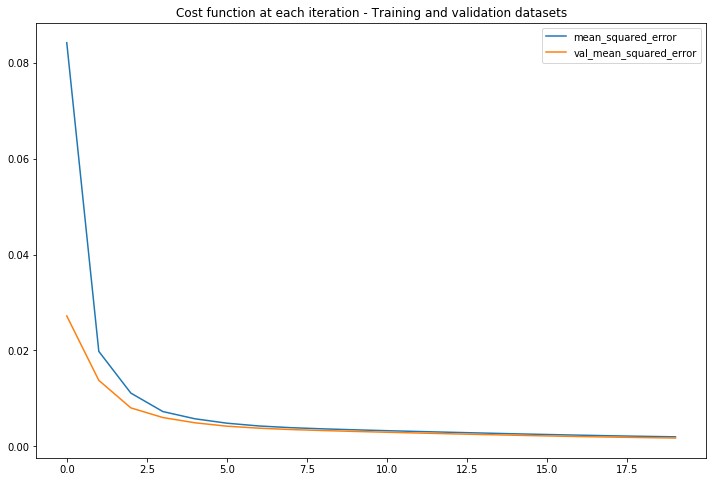

MSE threshold : 0.005256995626677518
false positive rate window    1 sample(s): 4.76 %
false positive rate window    2 sample(s): 0.27 %
false positive rate window    3 sample(s): 0.64 %
false positive rate window    4 sample(s): 0.05 %
Optimal window size : 4
CPU times: user 7.95 s, sys: 645 ms, total: 8.6 s
Wall time: 5.56 s


In [16]:
%%time

ad = AnomalyDetector()
ad.fit(X_train_ae, X_valid_ae)

## Evaluate

In [17]:
for name, df in datasets:
    X, y = build_test_dataset(X_test, df)
    X = prepare_data_for_test(X, scaler_train)
    # tpr, fnr, fpr, precision = ad.score(X, y, ws=None)
    # print("Dataset {:20s} : recall = {:2.2f} %, precision = {:2.2f} %, fnr = {:2.2f} %, fpr = {:2.2f} %".format(name, 100 * tpr, 100 * precision, 100 * fnr, 100 * fpr))
    tpr, fnr, fpr, precision = ad.score(X, y)
    print("Dataset {:20s} : recall = {:2.2f} %, precision = {:2.2f} %, fnr = {:2.2f} %, fpr = {:2.2f} %".format(name, 100 * tpr, 100 * precision, 100 * fnr, 100 * fpr))

/home/drussier/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Dataset mirai - ack          : recall = 100.00 %, precision = 99.91 %, fnr = 0.00 %, fpr = 4.89 %


/home/drussier/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Dataset mirai - udp          : recall = 100.00 %, precision = 99.93 %, fnr = 0.00 %, fpr = 4.89 %


/home/drussier/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Dataset mirai - syn          : recall = 100.00 %, precision = 99.91 %, fnr = 0.00 %, fpr = 4.89 %


/home/drussier/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Dataset mirai - udpplain     : recall = 100.00 %, precision = 99.88 %, fnr = 0.00 %, fpr = 4.89 %


/home/drussier/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Dataset mirai - scan         : recall = 100.00 %, precision = 99.75 %, fnr = 0.00 %, fpr = 4.89 %


/home/drussier/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Dataset gafgyt - udp         : recall = 100.00 %, precision = 99.90 %, fnr = 0.00 %, fpr = 4.89 %


/home/drussier/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Dataset gafgyt - junk        : recall = 100.00 %, precision = 99.65 %, fnr = 0.00 %, fpr = 4.89 %


/home/drussier/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Dataset gafgyt - combo       : recall = 100.00 %, precision = 99.80 %, fnr = 0.00 %, fpr = 4.89 %


/home/drussier/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Dataset gafgyt - scan        : recall = 100.00 %, precision = 99.61 %, fnr = 0.00 %, fpr = 4.89 %


/home/drussier/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Dataset gafgyt - tcp         : recall = 100.00 %, precision = 99.89 %, fnr = 0.00 %, fpr = 4.89 %


Recall of 100 % : all anomalous samples are retrieved by the detector  
Precision > 99.7 % : almost all predicted anomalies are true anomalies  
False negative rate is null : there is non false negative, ie the model does not miss anomalies  
False positive rate < 5 % : same values for all datasets because number of negative and false positive is the same   

Conclusion : the model slightly overpredicts anomalies but does miss none of them.